<a href="https://colab.research.google.com/github/vicmcl/ml-laptime/blob/main/ml_laptime/notebook/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from pathlib import Path
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [29]:
# Mount Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "laptime-simulation"

Mounted at /content/drive


In [30]:
data_path = glob.glob(str(ML_PATH / "races_*.pkl"))

In [31]:
pip install -q fastf1

In [32]:
data_path

['/content/drive/MyDrive/Projects/laptime-simulation/races_2021.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2020.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2019.pkl']

In [40]:
data = {}

for path in data_path:
    with open(path, "rb") as f:
        data[int(path.split(".")[0][-4:])] = pickle.load(f)

In [6]:
columns_laps = [
    'Time', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
    'Compound', 'TyreLife', 'LapTime', 'PitOutTime', 'PitInTime'
]

columns_telemetry = ['SessionTime', 'Throttle', 'Brake', 'DRS']

columns_weather = ['Time', 'TrackTemp', 'WindSpeed']

compound_map = {
    'SOFT': 1.0,
    'MEDIUM': 2.0,
    'HARD': 3.0
}

In [93]:
def process_track_status(gp, year):
    track_status = data[year][gp]['status'].copy()
    track_status['Incident'] = track_status['Status'].map(lambda s: False if s == '1' else True)
    mask = track_status['Incident'] & track_status['Incident'].shift(1)
    track_status = track_status[~mask][['Time', 'Incident']]
    return track_status

In [154]:
def laps_with_incident(laps, incident_times, allclear_times):
    laps_to_remove = []
    # Loop over every incident
    for start_incident, end_incident in zip(incident_times, allclear_times):
        i = 0
        # Find the first impacted lap
        while laps.iloc[i]['Time'] < start_incident:
            i += 1
        laps_to_remove.append(laps.iloc[i]['Time'])

        # If the incident is not over by the end of the lap, remove the next lap
        # and repeat until the incident is over
        while laps.iloc[i]['Time'] < end_incident:
            laps_to_remove.append(laps.iloc[i + 1]['Time'])
            i += 1
    return laps_to_remove

In [153]:
def remove_incidents(laps, track_status):
    laps_data = laps.copy()
    incident_times = track_status[track_status['Incident'] == True]['Time'].tolist()
    allclear_times = track_status[track_status['Incident'] == False]['Time'].iloc[1:].tolist()
    laps_to_remove = laps_with_incident(laps_data, incident_times, allclear_times)
    laps_data = laps_data[~laps_data["Time"].isin(laps_to_remove)]
    return laps_data

In [227]:
def remove_pitstops(laps):
    laps_data = laps.copy()
    mask = pd.isnull(laps_data['PitOutTime']) & pd.isnull(laps_data['PitInTime'])
    laps_data = laps_data[mask]
    laps_data = laps_data.drop(['PitOutTime', 'PitInTime'], axis=1)
    return laps_data

In [169]:
def process_lap_data(gp, year):
    laps_data = data[year][gp]['laps'][columns_laps].copy()
    laps_data['Season'] = year
    laps_data = laps_data.reset_index().drop('index', axis=1)
    laps_data['Compound'] = laps_data['Compound'].map(lambda x: compound_map.get(x, 0.0))
    laps_data = remove_pitstops(laps_data)
    track_status = process_track_status(gp, year)
    laps_data = remove_incidents(laps_data, track_status)
    return laps_data

In [8]:
def map_drs(drs):
    if drs >= 10:
        return True
    else:
        return False

def process_telemetry_data(gp, year, laps):
    telemetry_data = data[year][gp]['telemetry'][columns_telemetry].copy()
    telemetry_with_laps = pd.merge_asof(
        telemetry_data,
        laps[['Time', 'LapNumber']],
        left_on='SessionTime',
        right_on='Time',
        direction='forward'
    ).drop('Time', axis=1)
    telemetry_with_laps.loc[:, 'DRS'] = telemetry_with_laps['DRS'].map(map_drs)
    telemetry_avg = telemetry_with_laps.groupby('LapNumber').mean()
    return telemetry_avg

In [9]:
def process_weather_data(gp, year):
    weather_data = data[year][gp]['weather'][columns_weather].copy()
    return weather_data

In [10]:
def merge_data(laps, weather, telemetry):
    merged_data = pd.merge_asof(laps, weather, on='Time', direction='nearest').set_index('LapNumber').drop('Time', axis=1)
    merged_data = pd.concat([merged_data, telemetry], axis=1).reset_index()
    merged_data = merged_data.drop('SessionTime', axis=1)
    merged_data.loc[:, 'LapTime'] = merged_data['LapTime'].map(lambda x: x.total_seconds())
    return merged_data

In [11]:
def preprocess_data(gp, year):
    laps = process_lap_data(gp, year)
    weather = process_weather_data(gp, year)
    telemetry = process_telemetry_data(gp, year, laps)
    merged_data = merge_data(laps, weather, telemetry)
    return merged_data

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

si = SimpleImputer()

In [412]:
gp = 'Bahrain Grand Prix'
df = pd.DataFrame()

for year in sorted(list(data.keys())):
    laps = process_lap_data(gp, year)
    weather = process_weather_data(gp, year)
    telemetry = process_telemetry_data(gp, year, laps)
    merged_data = merge_data(laps, weather, telemetry)
    for col in merged_data.columns:
        merged_data[col] = si.fit_transform(merged_data[[col]])
    df = pd.concat([df, merged_data])

df = df.reset_index(drop=True)
df = df.dropna(subset='LapTime')

df['Lag1_LapTime'] = df['LapTime'].shift(1)
#df['Lag2_LapTime'] = df['LapTime'].shift(2)
df['Rolling2_LapTime'] = df['LapTime'].shift(1).rolling(window=2).mean()
#df['Rolling5_LapTime'] = df['LapTime'].shift(1).rolling(window=5).mean()

In [425]:
df.info()

<class 'fastf1.core.Laps'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LapNumber         128 non-null    float64
 1   Stint             128 non-null    float64
 2   SpeedI1           128 non-null    float64
 3   SpeedI2           128 non-null    float64
 4   SpeedFL           128 non-null    float64
 5   SpeedST           128 non-null    float64
 6   Compound          128 non-null    float64
 7   TyreLife          128 non-null    float64
 8   LapTime           128 non-null    float64
 9   Season            128 non-null    float64
 10  TrackTemp         128 non-null    float64
 11  WindSpeed         128 non-null    float64
 12  Throttle          128 non-null    float64
 13  Brake             128 non-null    float64
 14  DRS               128 non-null    float64
 15  Lag1_LapTime      127 non-null    float64
 16  Rolling2_LapTime  126 non-null    float64
dtypes: float

In [413]:
laps_to_predict = 2
remaining_laps = 15

df_train, df_test = df.iloc[:-remaining_laps], df.iloc[-remaining_laps:-remaining_laps + laps_to_predict]

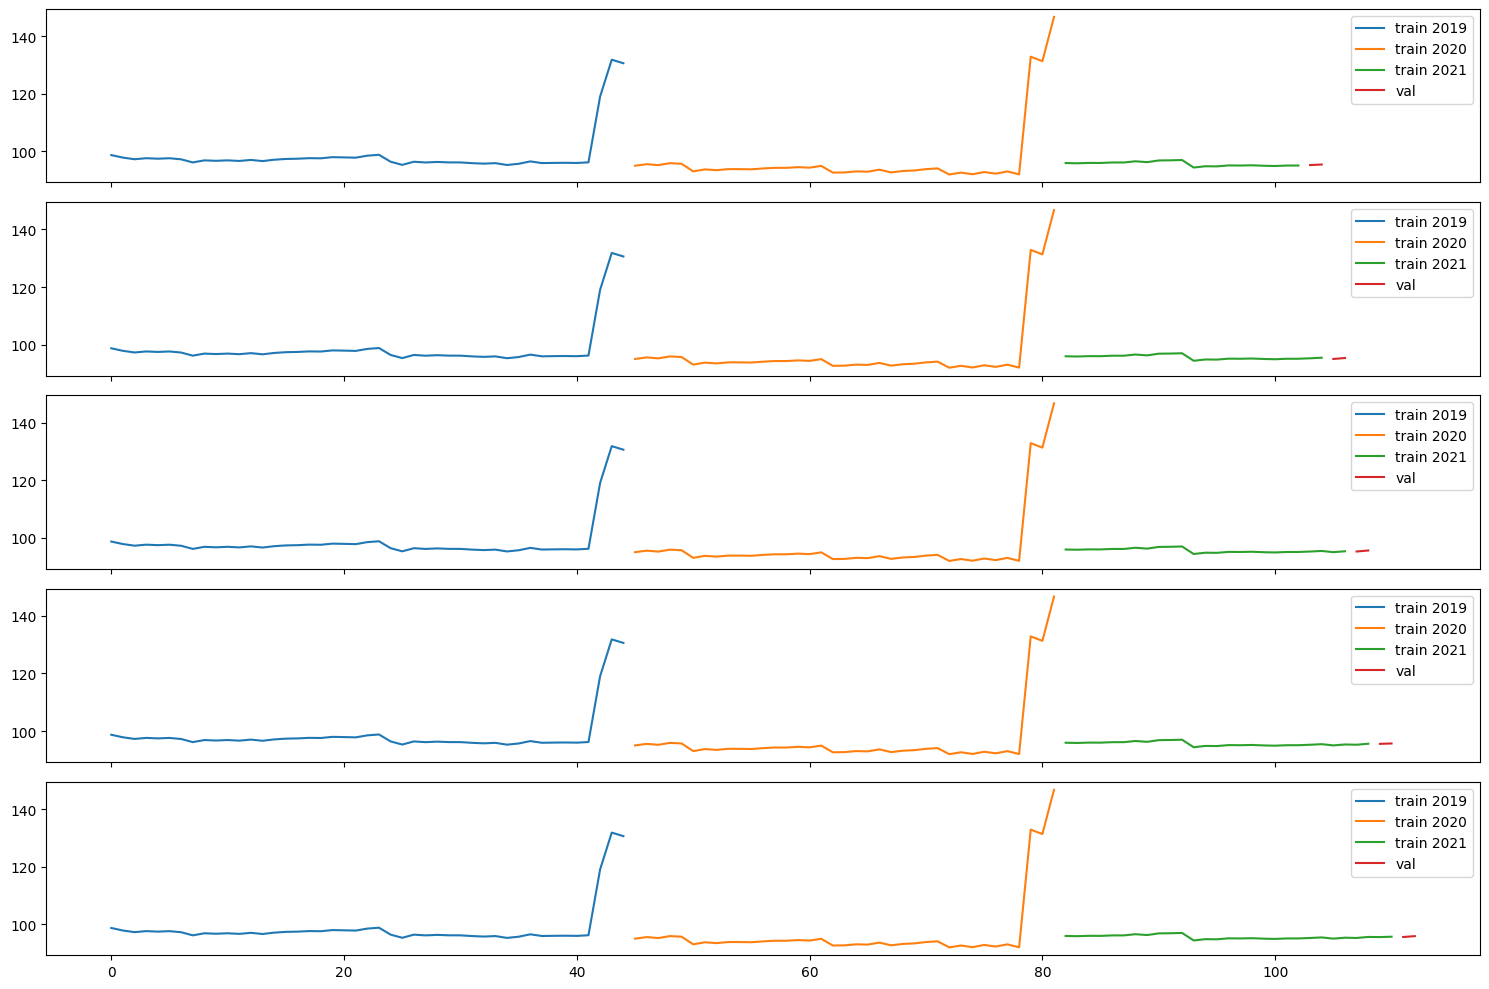

In [414]:
from sklearn.model_selection import TimeSeriesSplit

n_splits = 5
tss = TimeSeriesSplit(n_splits=n_splits, test_size=laps_to_predict)

fig, axs = plt.subplots(n_splits, 1, figsize=(15, 10), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df_train):
    train = df_train.loc[train_idx]
    val = df_train.loc[val_idx]
    train[train['Season'] == 2019]['LapTime'].plot(ax=axs[fold], label='train 2019')
    train[train['Season'] == 2020]['LapTime'].plot(ax=axs[fold], label='train 2020')
    train[train['Season'] == 2021]['LapTime'].plot(ax=axs[fold], label='train 2021')
    val['LapTime'].plot(ax=axs[fold], label='val')
    axs[fold].legend()
    fold += 1
plt.tight_layout()
plt.show()

In [415]:
def select_speed_trap(data):
    corr = data[['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']].corr()
    speed_trap = corr['LapTime'].iloc[1:].abs().idxmax()
    return speed_trap

def filter_speed_trap(data, speed_trap):
    data = data.drop([speed for speed in ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST'] if speed != speed_trap], axis=1)
    data = data.rename(columns={speed_trap: 'SpeedTrap'})
    return data

In [416]:
for train_idx, val_idx in tss.split(df_train):
    break

speed_trap = select_speed_trap(df_train.loc[train_idx])

df_train = filter_speed_trap(df_train, speed_trap)
df_test = filter_speed_trap(df_test, speed_trap)

In [417]:
FEATURES = list(df_train.columns)
FEATURES.remove('LapTime')
TARGET = 'LapTime'

In [418]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

preds = []
scores = []

for train_idx, val_idx in tss.split(df_train):
    X_train, y_train = df_train.loc[train_idx, FEATURES], df_train.loc[train_idx, TARGET]
    X_val, y_val = df_train.loc[val_idx, FEATURES], df_train.loc[val_idx, TARGET]

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        early_stopping_rounds=50,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    y_pred = model.predict(X_val)
    preds.append(y_pred)
    score = mean_squared_error(y_val, y_pred, squared=False)
    scores.append(score)

[0]	validation_0-rmse:2.23500
[100]	validation_0-rmse:0.70798
[200]	validation_0-rmse:0.14305
[287]	validation_0-rmse:0.12875
[0]	validation_0-rmse:2.35897
[100]	validation_0-rmse:0.89359
[200]	validation_0-rmse:0.40459
[300]	validation_0-rmse:0.24202
[400]	validation_0-rmse:0.20434
[500]	validation_0-rmse:0.13702
[600]	validation_0-rmse:0.10801
[700]	validation_0-rmse:0.10403
[717]	validation_0-rmse:0.10226
[0]	validation_0-rmse:2.07079
[100]	validation_0-rmse:0.57118
[200]	validation_0-rmse:0.34598
[245]	validation_0-rmse:0.38127
[0]	validation_0-rmse:1.83165
[100]	validation_0-rmse:0.12054
[161]	validation_0-rmse:0.31596
[0]	validation_0-rmse:1.69097
[100]	validation_0-rmse:0.28173
[184]	validation_0-rmse:0.31777


In [419]:
import numpy as np

print('Score across folds:', np.mean(scores))

Score across folds: 0.15031854475499604


In [420]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    early_stopping_rounds=50,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    verbose=100
)

[0]	validation_0-rmse:8.47685
[100]	validation_0-rmse:3.88205
[200]	validation_0-rmse:2.05285
[300]	validation_0-rmse:1.19855
[400]	validation_0-rmse:0.74613
[500]	validation_0-rmse:0.49299
[600]	validation_0-rmse:0.34985
[700]	validation_0-rmse:0.27376
[800]	validation_0-rmse:0.23040
[900]	validation_0-rmse:0.20009
[999]	validation_0-rmse:0.17260


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [421]:
df_test['Preds'] = model.predict(df_test[FEATURES])

In [422]:
score_test = mean_squared_error(df_test['LapTime'], df_test['Preds'], squared=False)
print('Test Score:', score_test)

Test Score: 0.2500427686746502


In [423]:
(df_test['LapTime'] - df_test['Preds']).abs().mean()

0.22906945800781386

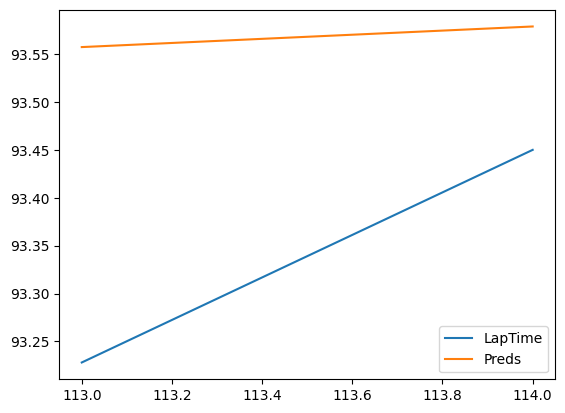

In [424]:
df_test['LapTime'].plot(label='LapTime')
df_test['Preds'].plot(label='Preds')
plt.legend()
plt.show()